### Make sure you have saved the featuremaps(activations) to npy files

In [1]:
import numpy as np
from scipy import linalg

fake = np.load(r'fake_emb.npy')
real = np.load(r'gt_emb.npy')

print(f'shape of fake: {fake.shape}')
print(f'shape of real: {real.shape}')

assert len(fake.shape) == 2

shape of fake: (4640, 512)
shape of real: (4640, 512)


### for some reason, the featuremaps might contain nan values, so we need to remove them
Here we remove by the row

In [5]:
remov_rows = []

if np.isnan(real).any():
    for i in range(real.shape[0]):
        for j in range(real.shape[1]):
            if np.isnan(real[i][j]):
                # print(i, j)
                remov_rows.append(i)
                break
real_safe = np.delete(real, remov_rows, axis=0)
print('Is there any nan left in the featuremap?', np.isnan(real_safe).any())

remov_rows = []
if np.isnan(fake).any():
    for i in range(real.shape[0]):
        for j in range(real.shape[1]):
            if np.isnan(fake[i][j]):
                # print(i, j)
                remov_rows.append(i)
                break
fake_safe = np.delete(fake, remov_rows, axis=0)
print('Is there any nan left in the featuremap?', np.isnan(fake_safe).any())

Is there any nan left in the featuremap? False
Is there any nan left in the featuremap? False


### Hypothsis Tests

In [6]:
# shapiro-wilk test
# null hypothesis: the sample is drawn from a normal distribution
# once sample amount is more than 5000, shapiro-wilk test will be not reliable

import scipy

for i in range(real_safe.shape[1]):
    x = real_safe[:, i]
    if scipy.stats.shapiro(x).pvalue < 0.05:
        print(f'{i}th dimension of ground truth motion featuremap is not normal distributed')

for i in range(fake_safe.shape[1]):
    x = fake_safe[:, i]
    if scipy.stats.shapiro(x).pvalue < 0.05:
        print(f'{i}th dimension of generated motion featuremap is not normal distributed')


0th dimension of ground truth motion featuremap is not normal distributed
1th dimension of ground truth motion featuremap is not normal distributed
2th dimension of ground truth motion featuremap is not normal distributed
3th dimension of ground truth motion featuremap is not normal distributed
4th dimension of ground truth motion featuremap is not normal distributed
5th dimension of ground truth motion featuremap is not normal distributed
6th dimension of ground truth motion featuremap is not normal distributed
7th dimension of ground truth motion featuremap is not normal distributed
8th dimension of ground truth motion featuremap is not normal distributed
9th dimension of ground truth motion featuremap is not normal distributed
10th dimension of ground truth motion featuremap is not normal distributed
11th dimension of ground truth motion featuremap is not normal distributed
12th dimension of ground truth motion featuremap is not normal distributed
13th dimension of ground truth moti

In [7]:
# Kolmogorov-Smirnov test
# null hypothesis: the two distributions are identical(default, two-sided)
# tests are valid only for continuous distributions
### if p-value < 0.05, the distribution is not identical to a normal distribution

from scipy.stats import kstest
normal_dist = np.random.randn(1000)
print(kstest(real_safe[:, 0],"norm"))   # here we use the first dimension of feature map for demonstration, should change it to all dimension
print(kstest(fake_safe[:, 0],"norm"))

KstestResult(statistic=0.6861443923701361, pvalue=0.0)
KstestResult(statistic=0.6859763663139373, pvalue=0.0)


In [8]:
# D’Agostino and Pearson’s
# null hypothesis: a sample comes from a normal distribution
### if p-value < 0.05, the distribution is not identical to a normal distribution

from scipy.stats import normaltest
normaltest(real_safe[:, 0])     # here we use the first dimension of feature map for demonstration, should change it to all dimension

NormaltestResult(statistic=77.35475674686636, pvalue=1.5945127560472322e-17)

### Illustrative Test

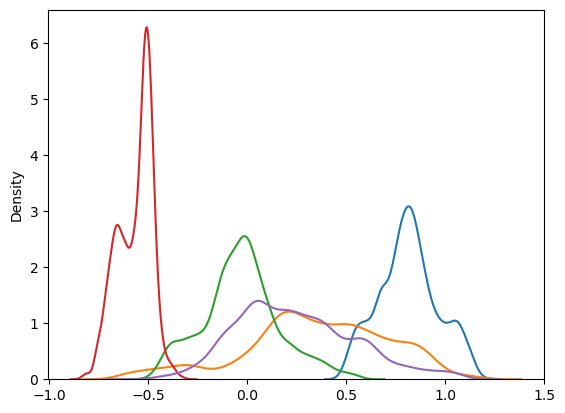

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(5):      # we illustrate the first 5 dimensions of feature map to see if they are normal distributed
    x = real_safe[:, i]
    sns.kdeplot(x, shade=False)

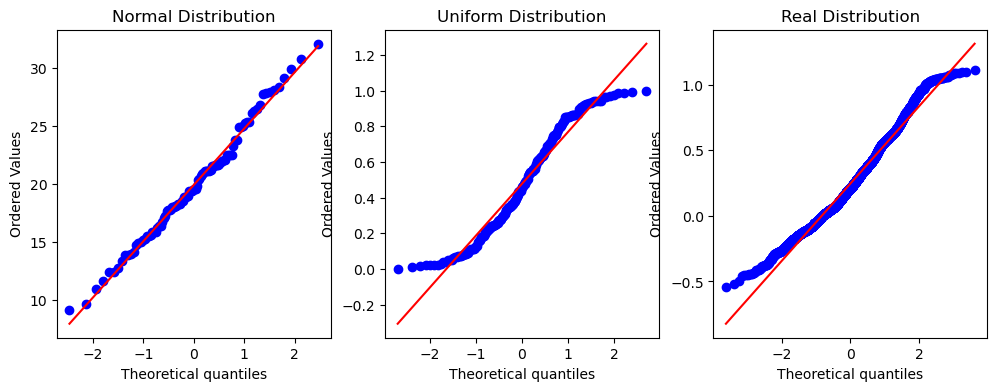

In [10]:
# probplot, PP plot 
### The PP plot of read data should be similar to that of ideal normal distribution

import numpy as np 
import pylab 
import scipy.stats as stats

data_normal = np.random.normal(loc = 20, scale = 5, size=100)      # ideal normal distribution
data_real = real_safe[:, i]      # real distribution
data_uni = np.random.rand(200)      # uniform distribution

plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 3, 1)
stats.probplot(data_normal, dist="norm", plot=pylab)
ax1.set_title("Normal Distribution")

ax2 = plt.subplot(1, 3, 2)
stats.probplot(data_uni, dist="norm", plot=pylab)
ax2.set_title("Uniform Distribution")

ax3 = plt.subplot(1, 3, 3)
stats.probplot(data_real, dist="norm", plot=pylab)
ax3.set_title("Real Distribution")

pylab.show()

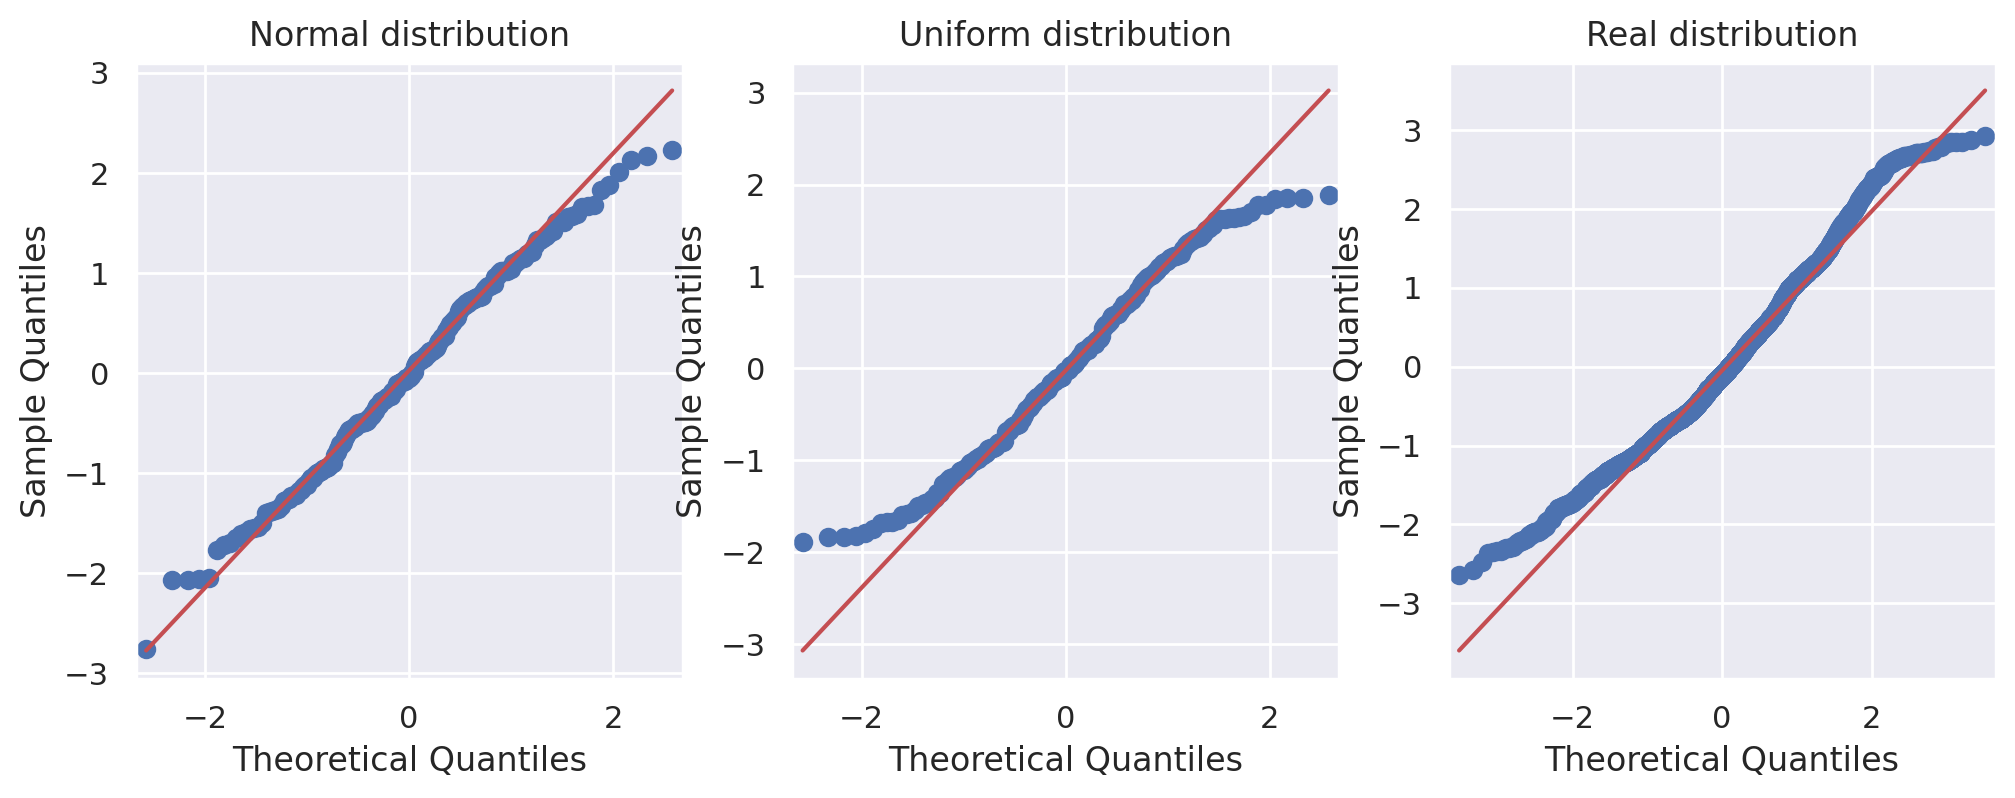

In [11]:
# qqplot
# not that ppplot and qqplot are different
### The QQ plot of read data should be similar to that of ideal normal distribution

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.api import qqplot
 
sns.set_theme()
%config InlineBackend.figure_format = 'retina'
 
mu, sigma = 0, 1
data_normal = np.random.normal(mu, sigma, 200)
data_uni = np.random.rand(200)
data_real = real_safe[:, i]

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
fig = qqplot(data_normal, line="q", ax=ax1, fit=True)
ax1.set_title("Normal distribution")

ax2 = fig.add_subplot(132)
fig = qqplot(data_uni, line="q", ax=ax2, fit=True)
ax2.set_title("Uniform distribution")

ax3 = fig.add_subplot(133)
fig = qqplot(data_real, line="q", ax=ax3, fit=True)
ax3.set_title("Real distribution")

plt.show()

### Calculate the FID score

In [12]:
real = real_safe
fake = fake_safe

n1 = fake.shape[0]
n2 = real.shape[0]

mean_fake = np.mean(real, axis=0)[None, ...]
mean_real = np.mean(fake, axis=0)[None, ...]

cov_fake_sum = fake.T @ fake - n1 * mean_fake.T @ mean_fake
cov_real_sum = real.T @ real - n2 * mean_real.T @ mean_real

cov_fake = cov_fake_sum / (n1 - 1)
cov_real = cov_real_sum / (n2 - 1)

In [13]:
mu1, mu2, sig1, sig2 = mean_fake, mean_real, cov_fake, cov_real
sig1sig2 = sig1 @ sig2

In [14]:
import torch

mu1_tensor = torch.tensor(mu1)
mu2_tensor = torch.tensor(mu2)
sig1_tensor = torch.tensor(sig1)
sig2_tensor = torch.tensor(sig2) 

a = (mu1_tensor - mu2_tensor).square().sum(dim=-1)
b = sig1_tensor.trace() + sig2_tensor.trace()
c = torch.linalg.eigvals(sig1_tensor @ sig2_tensor).sqrt().real.sum(dim=-1)

a + b - 2 * c

tensor([-0.5801])